In [18]:
import os,sys
import pandas as pd
import numpy as np

from multiprocessing import Pool
from functools import partial

import h5py as h5

import plotly.graph_objects as go

sensor_data = '/users/staff/federico/GitHub/CEUAS_master_SEPTEMBER2021/CEUAS/CEUAS/public/merge/utilities/sensor_tables/ALL'
merged = '/scratch/das/federico/MERGED_25FEB2022'


files = [f for f in  os.listdir(sensor_data) if 'all' not in f ]


sensor_configuration = 'sensor_configuration_all.csv'



## Extracting Data

In [2]:
def analyze_df(file):
    """ Extracts basic info from the sensor dataframe """
    
    sensor_data = '/users/staff/federico/GitHub/CEUAS_master_SEPTEMBER2021/CEUAS/CEUAS/public/merge/utilities/sensor_tables/ALL'
    merged = '/scratch/das/federico/MERGED_25FEB2022'

    
    s_file = sensor_data + '/' + file 
    
    df = pd.read_csv(s_file, sep = '\t')
    df['date_time_conv'] = pd.to_datetime( df['date_time_conv'][:] ).dt.date  #df['my_date_column'].dt.date
    
    ts = pd.Timestamp('2012-12-31')
    
    
    bef = df.loc[df['date_time_conv'] <= ts ]
    aft = df.loc[df['date_time_conv'] > ts ]


    
    m_file = merged + '/' + file.replace('_sensor.csv' , '_CEUAS_merged_v1.nc')
    
    sc = h5.File(m_file, 'r')['station_configuration']
    
    if len(bef) >0:
        s_bef = bef.sensor_id.values[-1]
        d_bef = bef.date_time_conv.values[-1] 
    else:
        s_bef =  'NA'
        d_bef =  pd.Timestamp('2050-12-31')
        

    if len(aft) >0:
        s_aft = aft.sensor_id.values[0]
        d_aft = aft.date_time_conv.values[0] 
    else:
        s_aft = 'NA'
        d_aft = pd.Timestamp('1900-12-31')
        
    try:
        r = { 's_bef': s_bef, 'd_bef': d_bef,
              's_aft': s_aft , 'd_aft': d_aft,
              'station_name': (b''.join(sc['station_name'][:])).decode('utf-8'),
              'lat': sc['latitude'][:][0],
              'lon': sc['longitude'][:][0],
              'primary_id': (b''.join(sc['primary_id'][:])).decode('utf-8'),
        }
        return r 
    except:
        
        print(file)
        r = { 's_bef': s_bef, 'd_bef': d_bef,
          's_aft': s_aft , 'd_aft': d_aft,
          'station_name': '',
          'lat': '',
          'lon': '',
          'primary_id': '',
        }
        return None 

    #print(m_file)





In [3]:
#c = pd.read_csv(files[0], sep = '\t')
#c['date_time_conv'] = pd.to_datetime( c['date_time_conv'][:] )

#a = analyze_df(files[0])
#type(a['s_bef'])
#a['s_bef']


In [4]:
# Running in multiproc

p    = Pool(30)
func = partial(analyze_df)
res  = p.map(func, files)

res = [f for f in res if f ]


0-20400-0-6124_sensor.csv


In [5]:
lats, lons, names, pids = [ r['lat'] for r in res] ,  [ r['lon'] for r in res] ,  [ r['station_name'] for r in res] , [ r['primary_id'] for r in res]
id_before, id_after = [ r['s_bef'] for r in res] ,  [ r['s_aft'] for r in res]
d_bef, d_aft = [ r['d_bef'] for r in res] , [ r['d_aft'] for r in res] 


In [6]:
data = pd.DataFrame( {'lat': lats, 'lon':lons, 'station_name':names, 'sensor_before': id_before , 'sensor_after': id_after , 'primary_id': pids,
                     'd_bef': pd.to_datetime(d_bef) , 'd_aft': pd.to_datetime(d_aft) }  )


In [7]:
data = pd.DataFrame( {'lat': lats, 'lon':lons, 'station_name':names, 'sensor_before': id_before , 'sensor_after': id_after , 'primary_id': pids,
                     'd_bef': d_bef , 'd_aft': d_aft }  )

In [8]:
data_before = data.loc[data['d_bef'] > np.datetime64('1990-01-01')]
data_after = data.loc[data['d_aft'] > np.datetime64('2012-12-30')]


## Global Sensor ID Map 

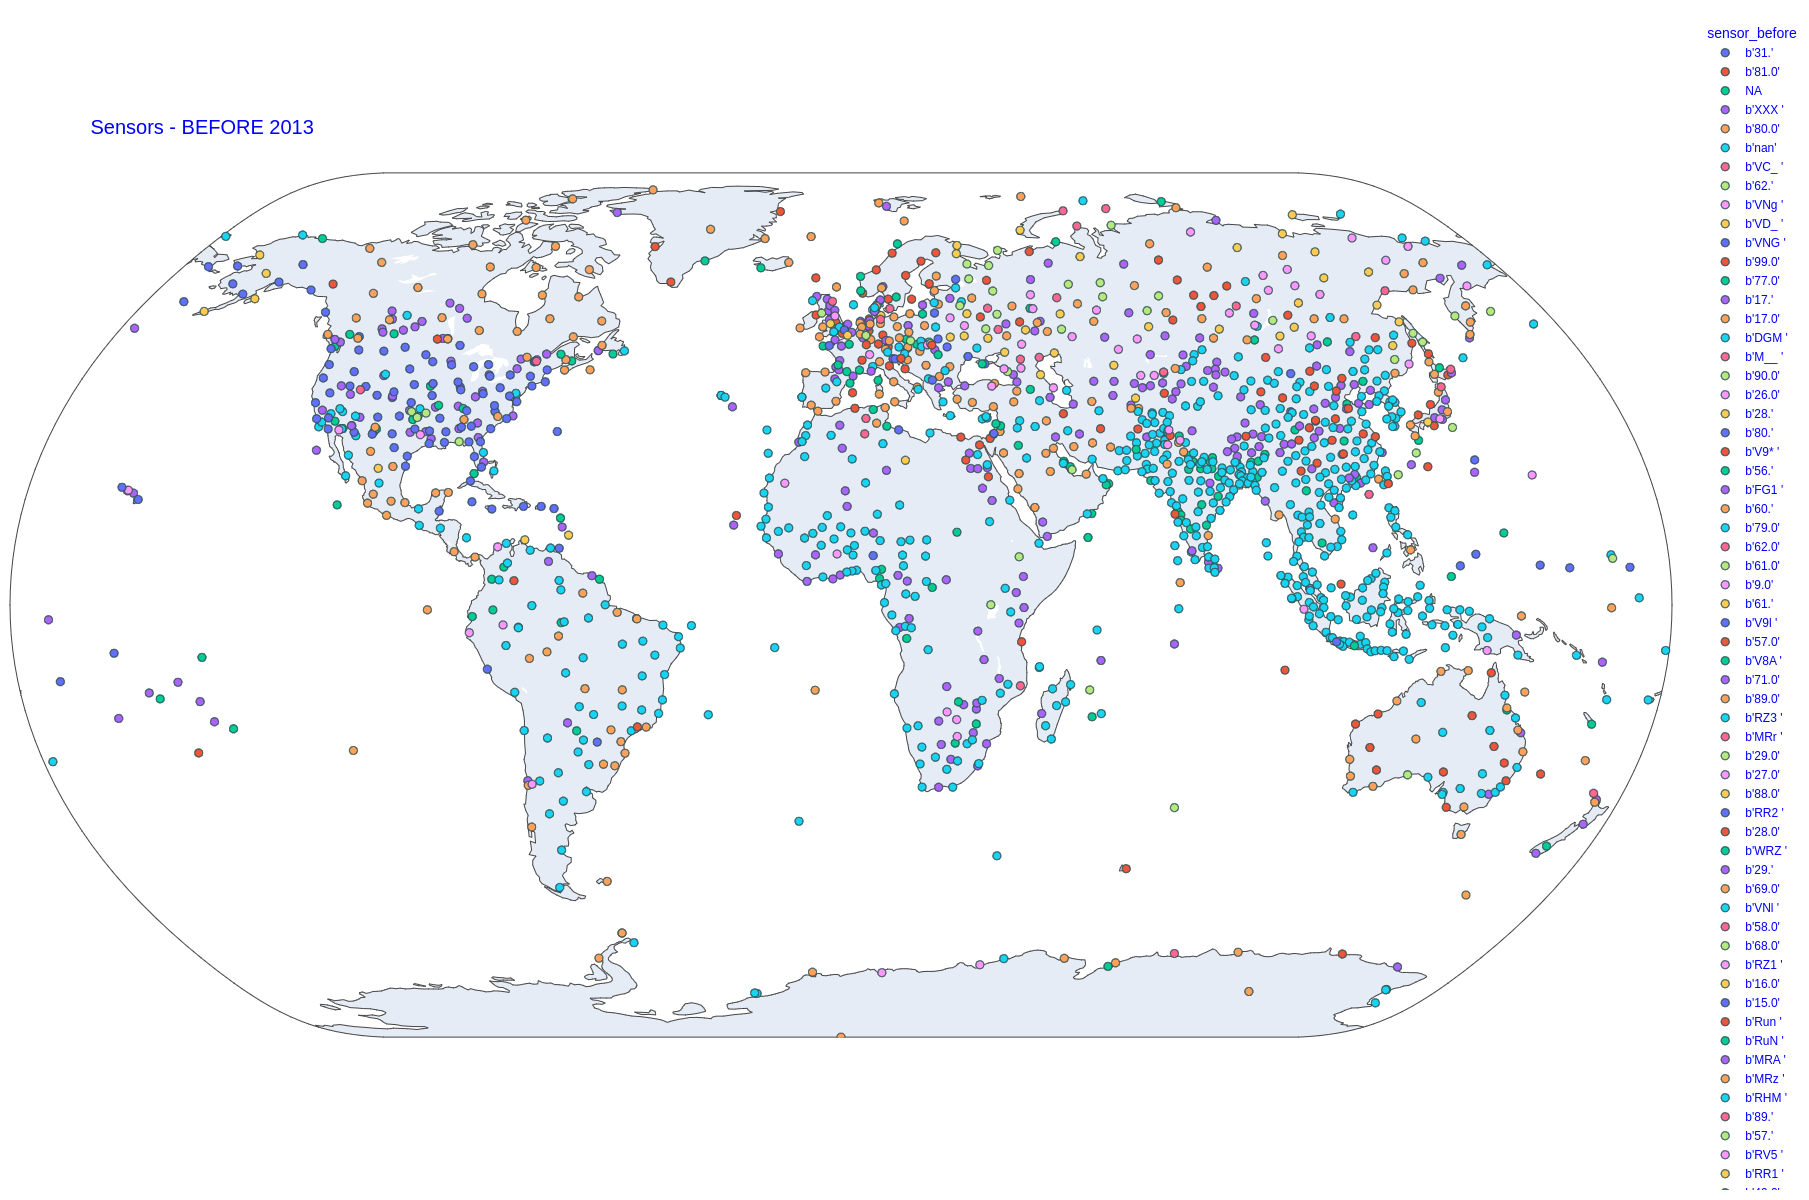

In [9]:
import plotly.express as px


fig = px.scatter_geo(data_before, 
                     lat = "lat",
                     lon = "lon",
                     color="sensor_before", # which column to use to set the color of markers
                     hover_name="primary_id", # column added to hover information
                     projection="natural earth",
                     hover_data=["sensor_before", "station_name"])

fig.update_layout(
    margin=dict(l=10, r=10, t=20, b=10),
    width= 1800, height = 1200)

# title
fig.update_layout(title_text='Sensors - BEFORE 2013 ',
                  title_y=0.9,
                  title_font_size=20,
                  font_color="blue",
                  
                  hoverlabel=dict(
                  bgcolor="white",
                  font_size=17,
                  #font_family="Rockwell"
                    )
)

fig.update_traces(marker=dict(size=8,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()



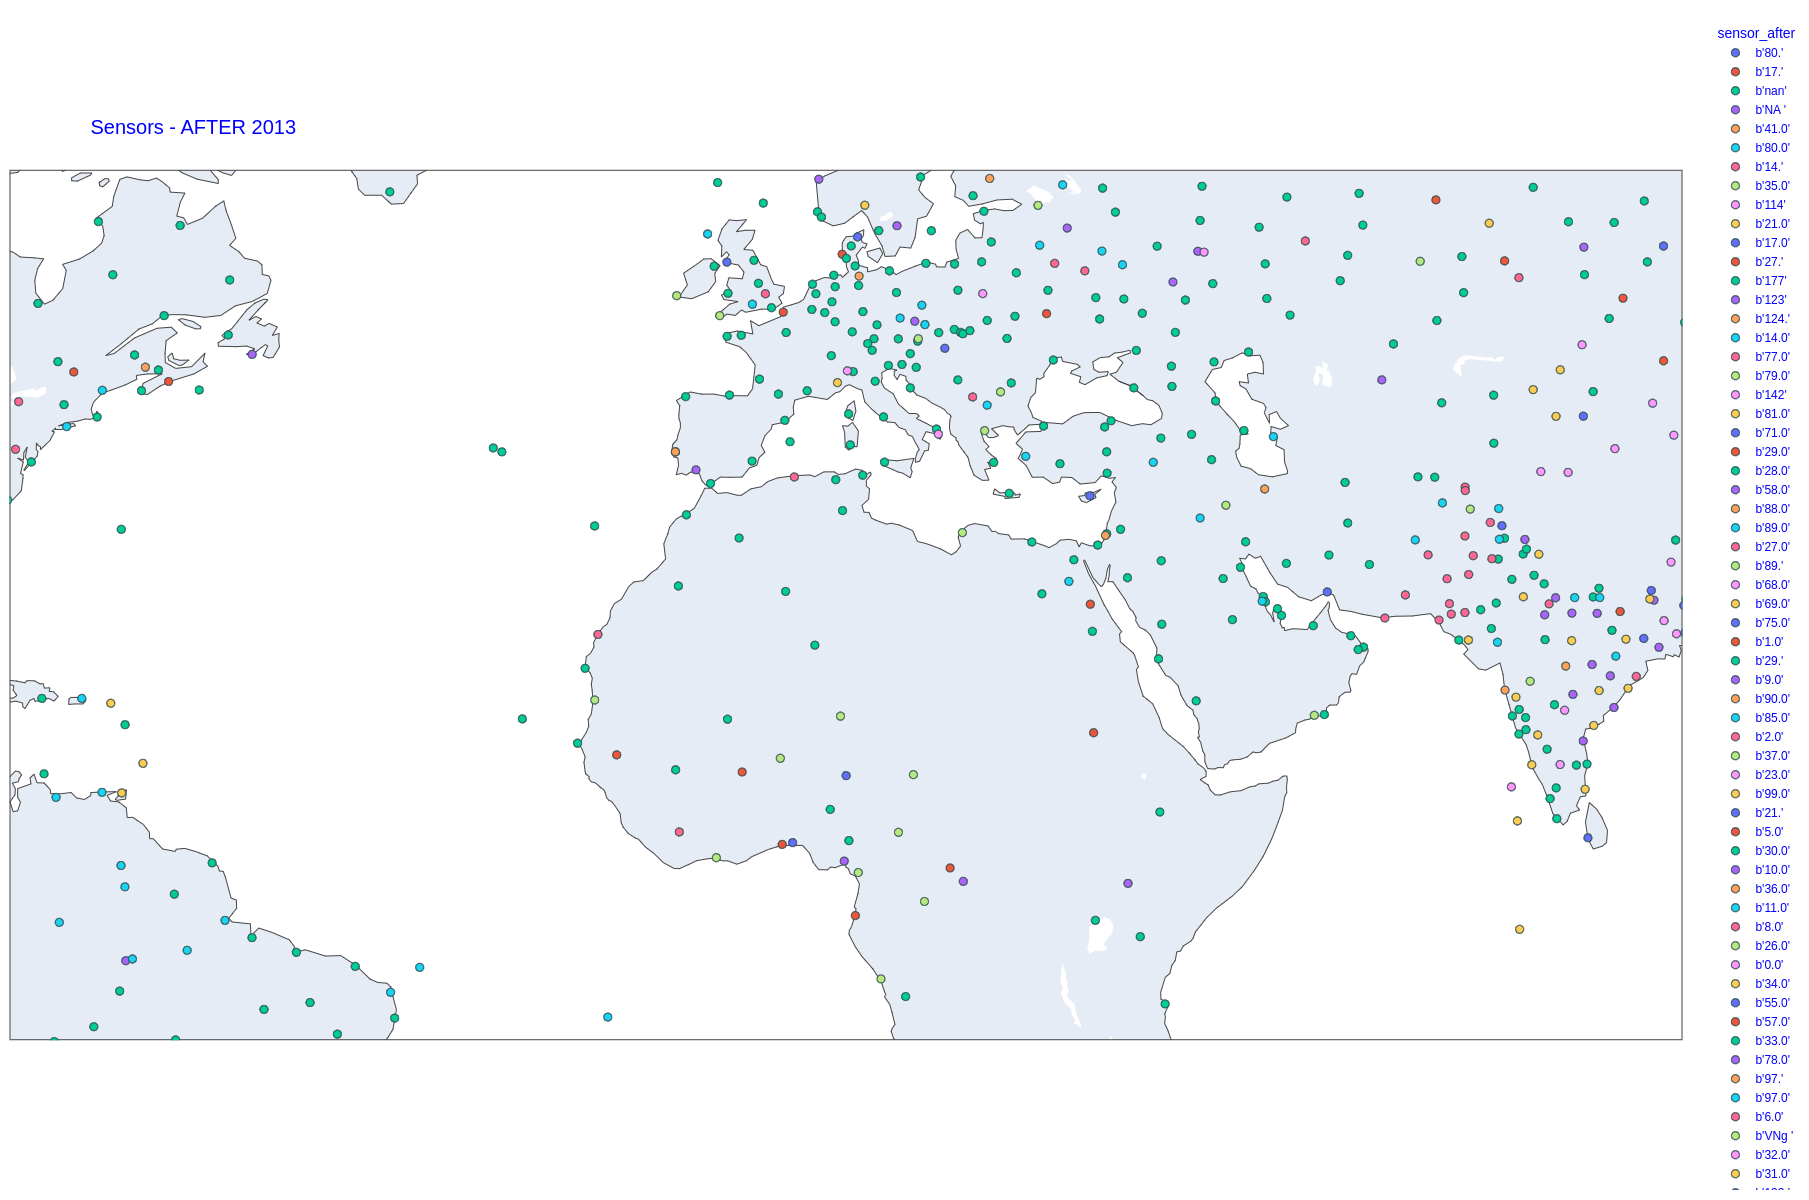

In [10]:
import plotly.express as px


fig = px.scatter_geo(data_after, 
                     lat = "lat",
                     lon = "lon",
                     color="sensor_after", # which column to use to set the color of markers
                     hover_name="primary_id", # column added to hover information
                     hover_data=["sensor_before", "station_name"],
                     projection="natural earth")

fig.update_layout(
    margin=dict(l=10, r=10, t=20, b=10),
    #paper_bgcolor="pink",
)

# fig size
fig.update_layout(width= 1800, height = 1200)

# title
fig.update_layout(title_text='Sensors - AFTER 2013 ',
                  title_y=0.9,
                  title_font_size=20,
)
fig.update_layout(
    font_color="blue",
                        hoverlabel=dict(
                        bgcolor="white",
                        font_size=17,
                        #font_family="Rockwell"
                    )
)

fig.update_traces(marker=dict(size=8,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))


fig.show()

In [11]:
sensor_conf = pd.read_csv( sensor_data +  '/sensor_configuration_all.csv', sep='\t',  index_col=0)

sensor_conf['sensor_id']

ids = []
for i in sensor_conf.sensor_id:
    try:
        ids.append( str( eval(i).decode('utf-8') ) )
    except:
        ids.append(str(i))
        
sensor_conf['sensor_id'] = ids


def get_sensor_id_comments(file, station, value, sensor_conf):
    """ Extracts the sensor ids from the reduced sensor summary tables, 
    and retrieves the description from the sensor_configuration table """
    
    sensor_data = '/users/staff/federico/GitHub/CEUAS_master_SEPTEMBER2021/CEUAS/CEUAS/public/merge/utilities/sensor_tables/ALL'
    
    s_file = sensor_data + '/' + file 
    
    df = pd.read_csv(s_file, sep = '\t')
        
    
    # list placeholders
    sensors, description  = [], []
    
    for s in df['sensor_id'].values:
        
        if 'na' in s:
            com = 'NA'
        else:
            a = s
            try:
                s = eval(s).decode('utf-8').replace(' ','')
                s = str(s)
            except:
                #print('failed:: ' , s)
                s = s

            d = sensor_conf[sensor_conf['sensor_id'] == s ]

            if d.empty:
                s = s.replace('.0', '').replace('.', '')
                if len(s) == 2 and int(s) != 80:
                    s = '1' + s
                elif len(s) ==2 and int(s)==80:
                    s = '80'
                d = sensor_conf[sensor_conf['sensor_id'] == s ]


            try:
                com = d.comments.values[0]
            except:
                com = 'NA'
            #print(a, ' ', s, ' ', len(s), ' ', type(s), ' ',  com)
        
        
        sensors.append(s)
        try:
            #print(type(com))
            com = eval(com).decode('utf-8')
        except:
            pass
        
        description.append(com)
    
    
    res = {'sensor_id'  : sensors,
           'description': description,
           'date_time'  : pd.to_datetime( df['date_time_conv'][:] ).dt.date }
    
    res['value'] = value
    res['station'] = station

    return pd.DataFrame( res )






    

In [12]:
# Creation of the sensor data for the plot 

lin = get_sensor_id_comments([f for f in files if '20001-0-10393' in f ][0], 'Lindenberg', 1, sensor_conf)
vie = get_sensor_id_comments([f for f in files if '20001-0-11035' in f ][0], 'Vienna', 2, sensor_conf)
pay = get_sensor_id_comments([f for f in files if '20000-0-06610' in f ][0], 'Payerne', 3, sensor_conf)
    

data = pd.concat ([lin,vie,pay])

In [13]:
#type(sensor_conf['sensor_id'].values[3413])
#data
# sensor_conf[3350:3380]
# sensor_conf[sensor_conf.sensor_id == "80"]

In [14]:
#import plotly.graph_objects as go
#import numpy as np


#fig = go.Figure(data=go.Scatter(x=data['date_time'],
#                                y=data['value'],
#                                mode='markers',
#                                #marker_color=data['sensor_id'],
#                                text=data['description'])) # hover text goes here

#fig.update_layout(title='Population of USA States')
#fig.update_yaxes( ticktext= ['Lindenberg', 'Vienna' , 'Payerne' ],
#                  tickvals= [1,2,3])


#fig.show()


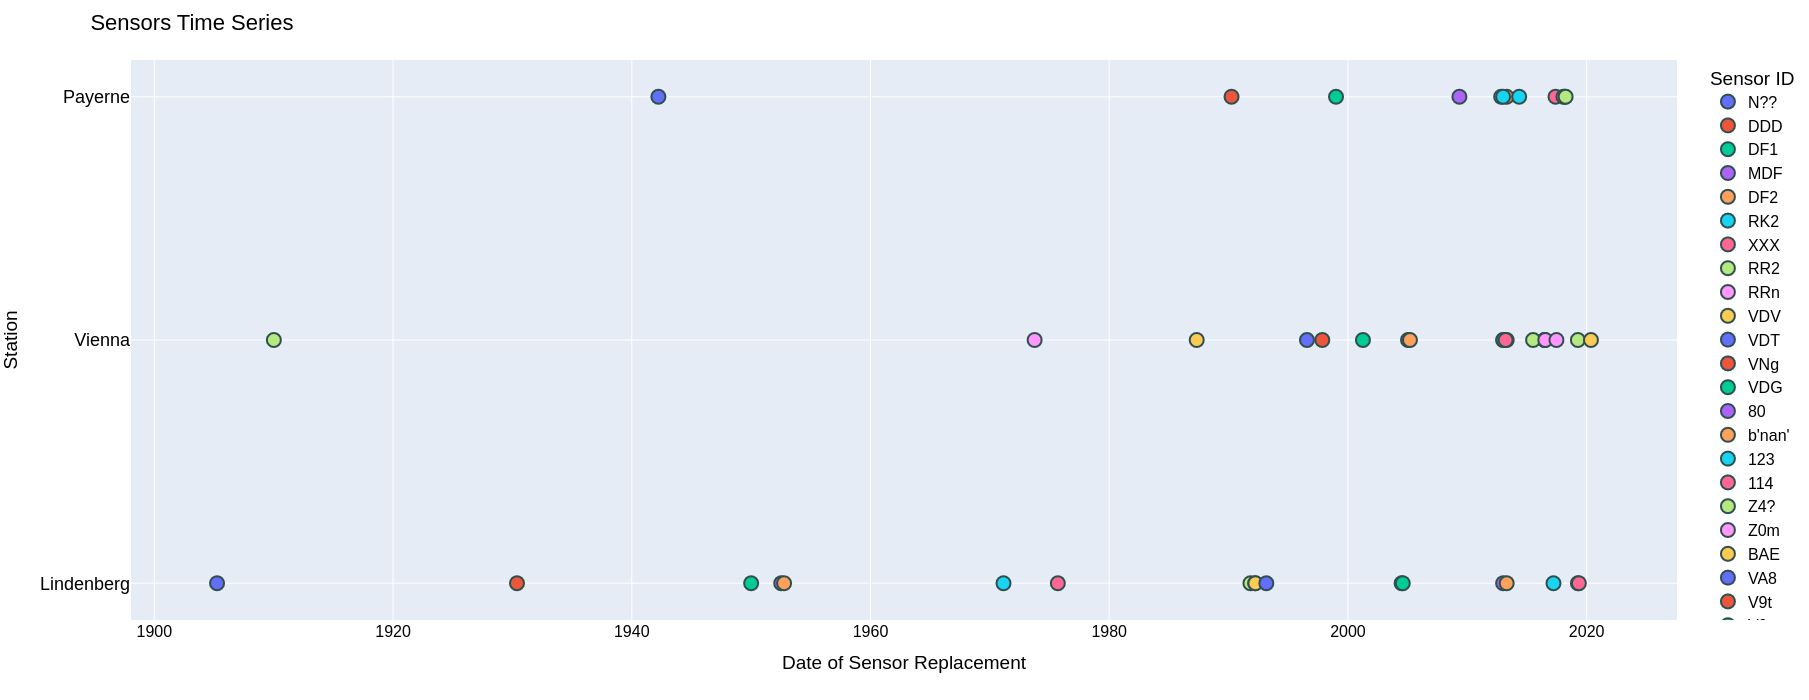

In [25]:
import plotly.express as px


fig = px.scatter(data, x="date_time", y="value", color="sensor_id",
                hover_name="station", hover_data=["description"]
                
                
                )

fig.update_layout(title='Sensors Time Series (Payerne, Vienna, Lindenberg)')
fig.update_yaxes( ticktext= ['Lindenberg', 'Vienna' , 'Payerne' ],
                  tickvals= [1,2,3])

fig.update_layout(width= 1900, height = 700)

fig.update_layout(
    xaxis_title="Date of Sensor Replacement",
    yaxis_title="Station",
    legend_title="Sensor ID",
    font=dict(
        size=16,
        color="black"
    )
)

fig.update_traces(marker=dict(size=14,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(hovermode="x unified")

fig.update_layout(
yaxis = dict(
tickfont = dict(size=18)))


fig.show()

In [16]:
#data.columns

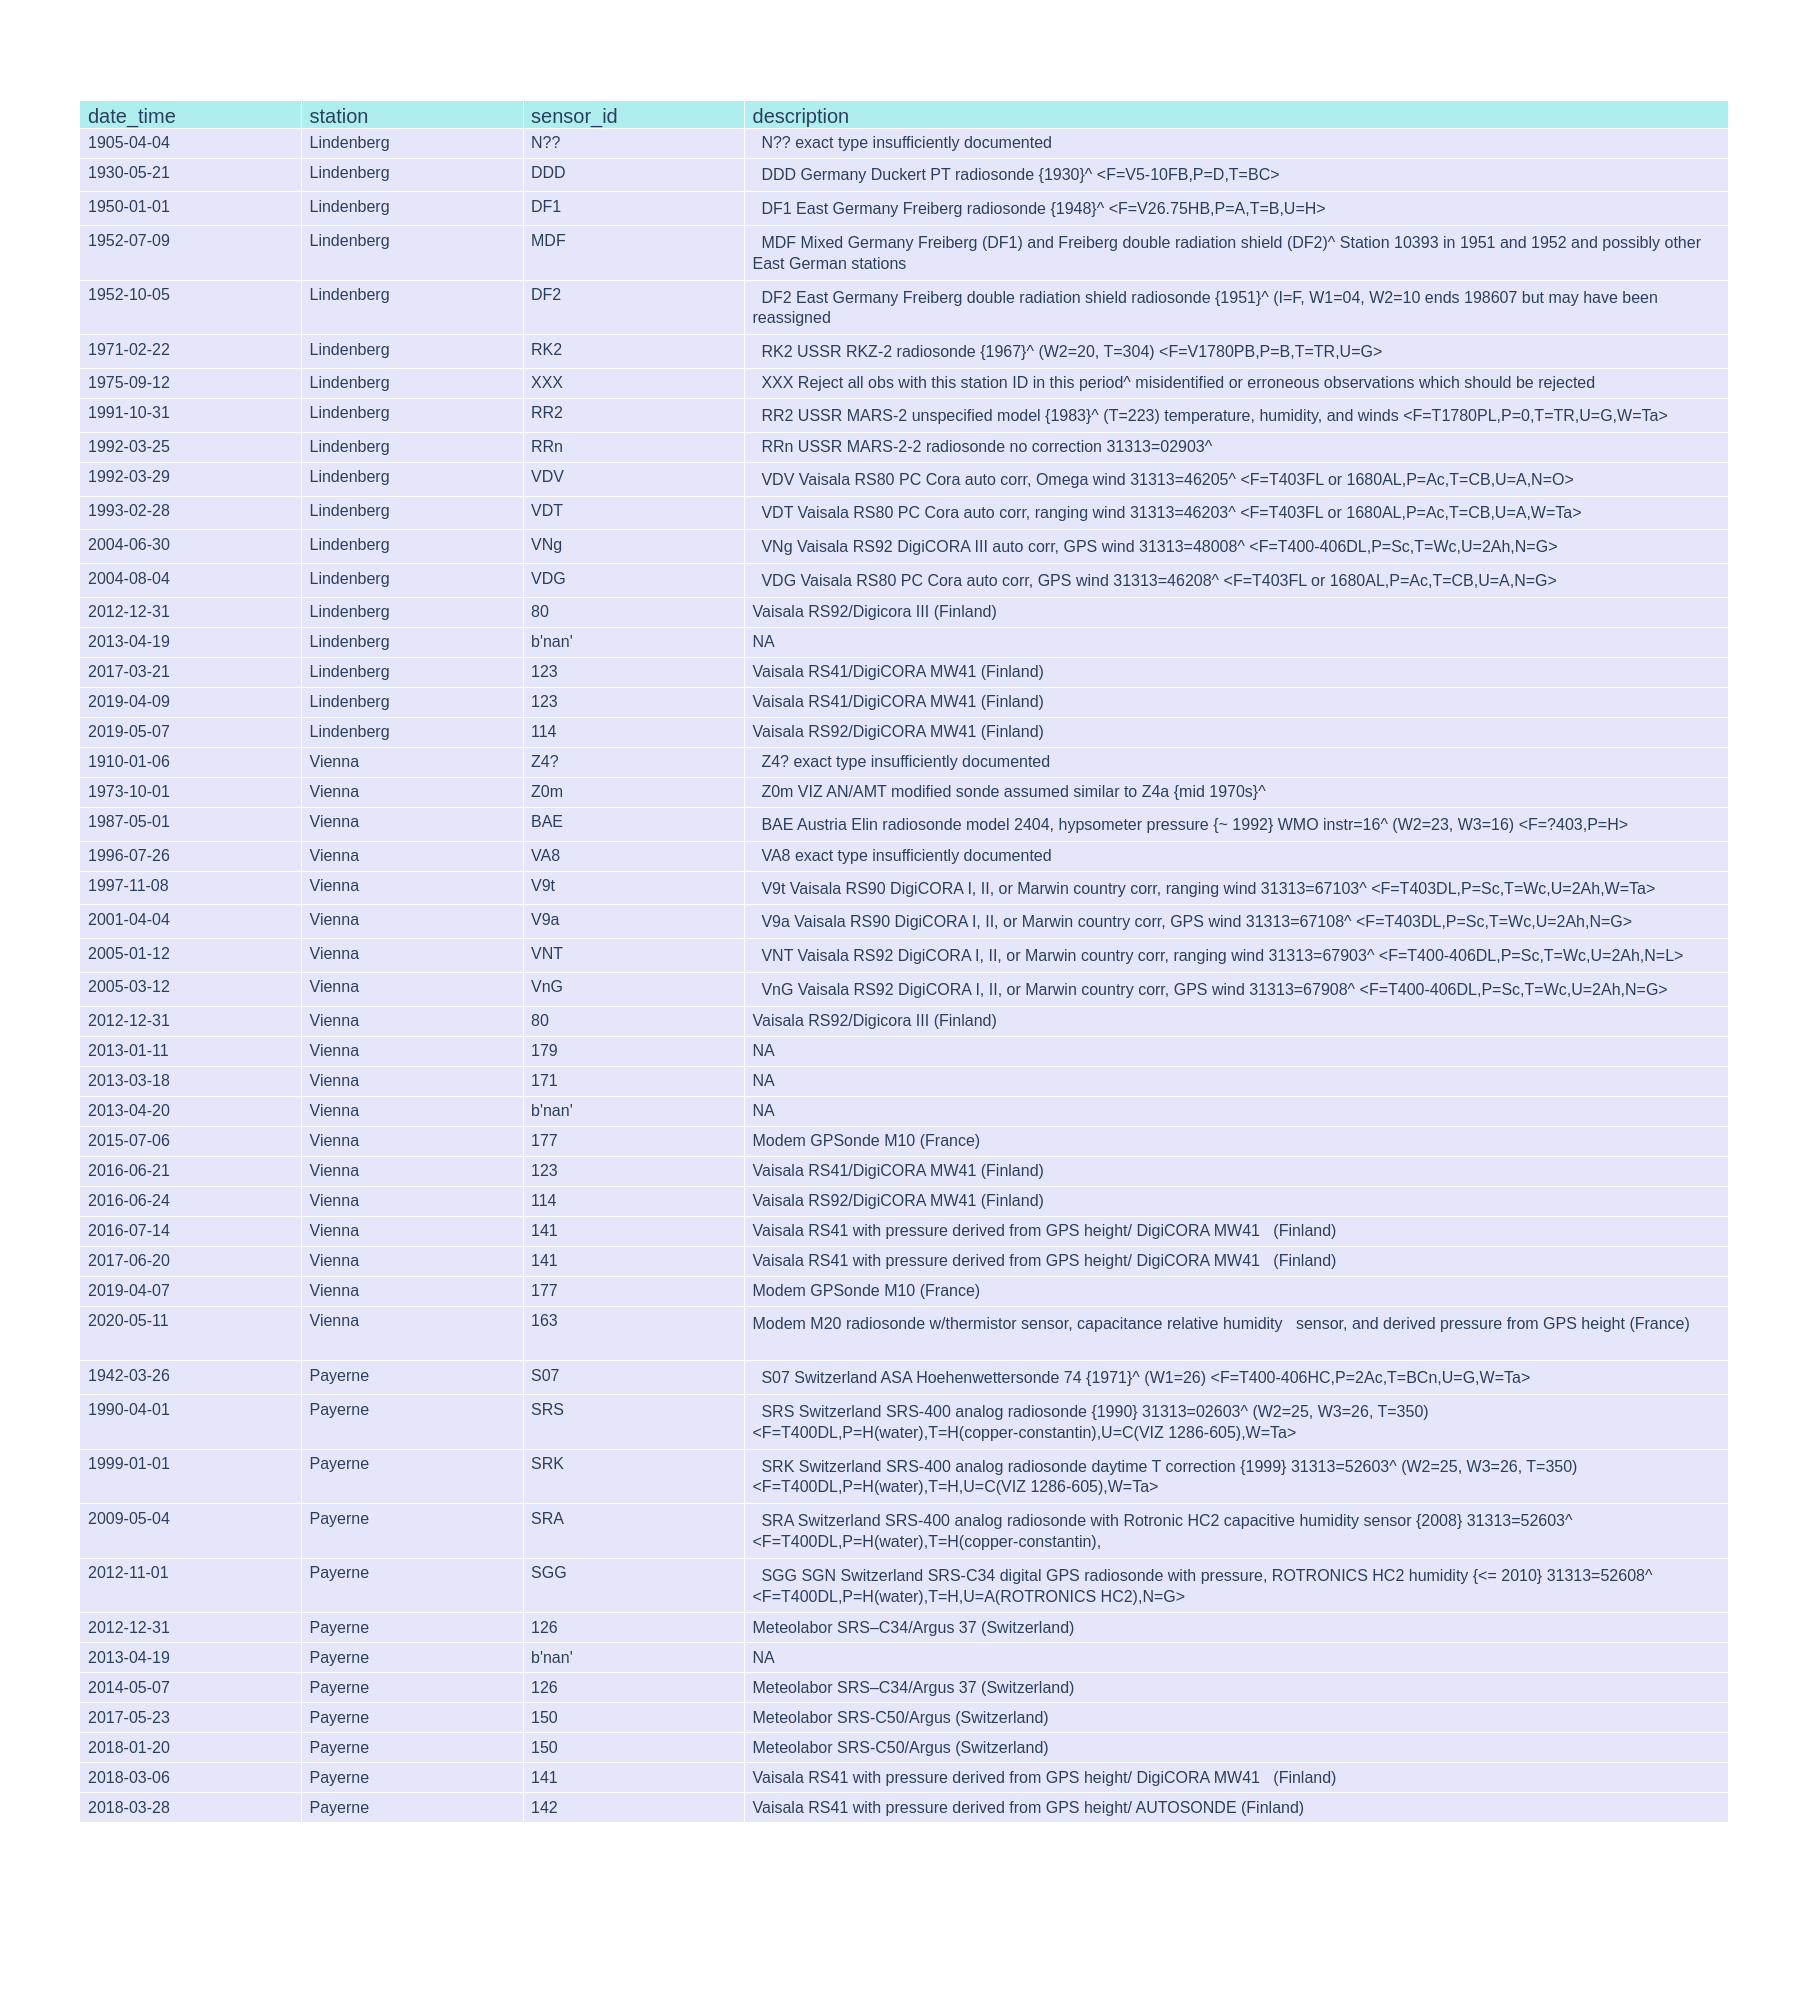

In [19]:

table = data.drop( columns=['value'])

fig = go.Figure(data=[go.Table(
    header=dict(values=list(['date_time','station', 'sensor_id' , 'description']),
                fill_color='paleturquoise',
                align='left',
               font_size=20),
    columnwidth = [90,90,90,400],
    cells=dict(values=[table.date_time, table.station, table.sensor_id, table.description],
               fill_color='lavender',
               align='left',
               font_size=16,
               height=30
              )),
])

fig.update_layout(width=2000, height=2000)

fig.show()

In [ ]:
"""
import plotly.graph_objects as go
import numpy as np

labels = ["apples","oranges","pears","bananas"]
widths = np.array([10,20,20,50])

data = {
    "South": [50,80,60,70],
    "North": [50,20,40,30]
}

fig = go.Figure()
for key in data:
    fig.add_trace(go.Bar(
        name=key,
        y=data[key],
        x=np.cumsum(widths)-widths,
        width=widths,
        offset=0,
        customdata=np.transpose([labels, widths*data[key]]),
        texttemplate="%{y} x %{width} =<br>%{customdata[1]}",
        textposition="inside",
        textangle=0,
        textfont_color="white",
        hovertemplate="<br>".join([
            "label: %{customdata[0]}",
            "width: %{width}",
            "height: %{y}",
            "area: %{customdata[1]}",
        ])
    ))

fig.update_xaxes(
    tickvals=np.cumsum(widths)-widths/2,
    ticktext= ["%s<br>%d" % (l, w) for l, w in zip(labels, widths)]
)

fig.update_xaxes(range=[0,100])
fig.update_yaxes(range=[0,100])

fig.update_layout(
    title_text="Marimekko Chart",
    barmode="stack",
    uniformtext=dict(mode="hide", minsize=10),
)
"""